# 3-3 高阶API示范

Pytorch没有官方的高阶API, 一般需要用户自定义训练循环、验证循环和预测循环。

这里通过仿照tf.keras.Model的功能对Pytorch的nn.Module进行了封装,

实现了fit、validate、predict、summary方法, 相当于用户自定义高阶API。

In [1]:
from torchkeras import Model, summary

## 一、线性回归模型

此范例通过继承用户自定义的Model, 实现线性回归模型

### 1.准备数据

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

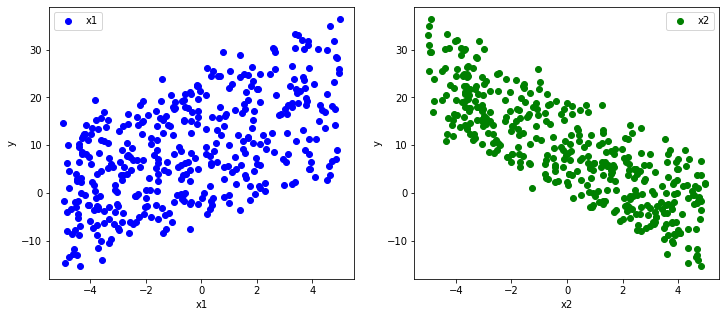

In [4]:
# 样本数量
n = 400

# 生成预测用的数据
x = 10*torch.rand([n, 2]) - 5.0
w0 = torch.tensor([[2.], [-3]])
b0 = torch.tensor([[10.0]])
y = x@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])

# 数据可视化
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y, c="b")
plt.legend(["x1"])
plt.xlabel("x1")
plt.ylabel("y")

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y, c="g")
plt.legend(["x2"])
plt.xlabel("x2")
plt.ylabel("y")

plt.show()

In [6]:
# 构建输入数据管道
ds = TensorDataset(x, y)
ds_train, ds_valid = torch.utils.data.random_split(ds, [int(400*0.7), 400-int(400*0.7)])
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True, num_workers=2)
dl_valid = DataLoader(ds_valid, batch_size=10, num_workers=2)

### 2.定义模型

In [9]:
# 继承用户自定义的模型
class LinearRegression(Model):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 1)
        
    def forward(self, x):
        return self.fc(x)
    
model = LinearRegression()
model.summary(input_shape=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


### 3.训练模型

In [12]:
def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_pred-y_true))

def mean_absolute_percent_error(y_pred, y_true):
    absolute_percent_error = (torch.abs(y_pred-y_true)+1e-7) / (torch.abs(y_true)+1e-7)
    return torch.mean(absolute_percent_error)
    
model.compile(loss_func=nn.MSELoss(),
              optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
             metrics_dict={"mae": mean_absolute_error, "mape": mean_absolute_percent_error})
dfhistory = model.fit(200, dl_train=dl_train, dl_val=dl_valid, log_step_freq=20)    

Start Training ...

================================================================================2020-09-20 11:13:45
{'step': 20, 'loss': 177.558, 'mae': 10.865, 'mape': 0.962}

 +-------+---------+--------+-------+----------+---------+----------+
| epoch |   loss  |  mae   |  mape | val_loss | val_mae | val_mape |
+-------+---------+--------+-------+----------+---------+----------+
|   1   | 178.902 | 10.879 | 0.958 | 128.103  |  8.965  |  1.053   |
+-------+---------+--------+-------+----------+---------+----------+

================================================================================2020-09-20 11:13:45
{'step': 20, 'loss': 153.502, 'mae': 10.104, 'mape': 1.175}

 +-------+---------+--------+------+----------+---------+----------+
| epoch |   loss  |  mae   | mape | val_loss | val_mae | val_mape |
+-------+---------+--------+------+----------+---------+----------+
|   2   | 157.776 | 10.248 | 1.1  | 113.983  |  8.497  |  1.243   |
+-------+---------+--------+------+---

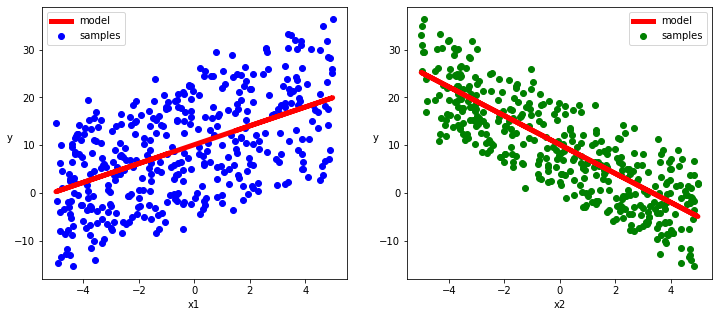

In [15]:
w, b = model.state_dict()["fc.weight"], model.state_dict()["fc.bias"]
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(x[:,0],y[:,0], c = "b",label = "samples")
ax1.plot(x[:,0],w[0,0]*x[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(x[:,1],y[:,0], c = "g",label = "samples")
ax2.plot(x[:,1],w[0,1]*x[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

### 4.评估模型

In [17]:
dfhistory.tail()

,loss,mae,mape,val_loss,val_mae,val_mape
195,4.017752,1.645054,0.756109,4.113720,1.641480,0.888487
196,4.026980,1.646807,0.772716,4.129773,1.645167,0.899459
197,4.017432,1.645541,0.761138,4.139308,1.647768,0.887285
198,4.035538,1.651955,0.760117,4.161452,1.652284,0.882577
199,4.036314,1.644542,0.750404,4.095155,1.637864,0.887597


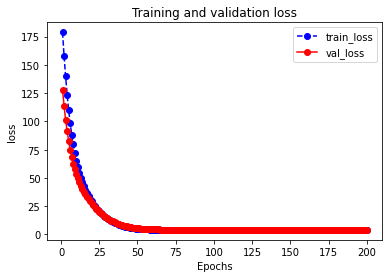

In [18]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    
plot_metric(dfhistory,"loss")

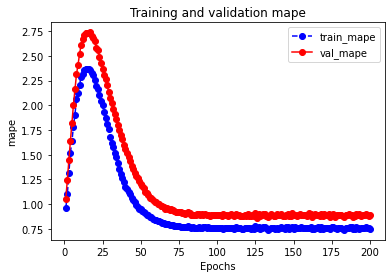

In [19]:
plot_metric(dfhistory,"mape")

In [20]:
# 评估
model.evaluate(dl_valid)

{'val_loss': 4.09515506029129,
 'val_mae': 1.6378635466098785,
 'val_mape': 0.88759729017814}

## 二、DNN二分类
同样是继承Model实现DNN二分类

### 1.准备数据

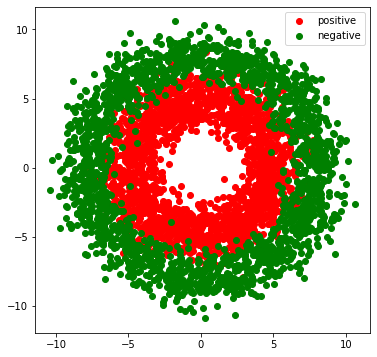

In [22]:
#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
yn = torch.zeros_like(r_n)

#汇总样本
x = torch.cat([xp,xn],axis = 0)
y = torch.cat([yp,yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(xp[:,0],xp[:,1],c = "r")
plt.scatter(xn[:,0],xn[:,1],c = "g")
plt.legend(["positive","negative"]);

In [23]:
ds = TensorDataset(x,y)

ds_train,ds_valid = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 100,num_workers=2)

### 2.定义模型

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 =  nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y

In [26]:
model = Model(Net())
model.summary(input_shape=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


### 3.训练模型

In [27]:
# 准确率
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                      torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func = nn.BCELoss(),optimizer= torch.optim.Adam(model.parameters(),lr = 0.01),
             metrics_dict={"accuracy":accuracy})

dfhistory = model.fit(100,dl_train = dl_train,dl_val = dl_valid,log_step_freq = 10)

Start Training ...

================================================================================2020-09-20 11:22:37
{'step': 10, 'loss': 0.673, 'accuracy': 0.507}
{'step': 20, 'loss': 0.661, 'accuracy': 0.53}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.655 |  0.545   |  0.629   |    0.619     |
+-------+-------+----------+----------+--------------+

================================================================================2020-09-20 11:22:37
{'step': 10, 'loss': 0.611, 'accuracy': 0.639}
{'step': 20, 'loss': 0.598, 'accuracy': 0.66}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   2   | 0.581 |   0.69   |  0.522   |    0.762     |
+-------+-------+----------+----------+--------------+

======================================

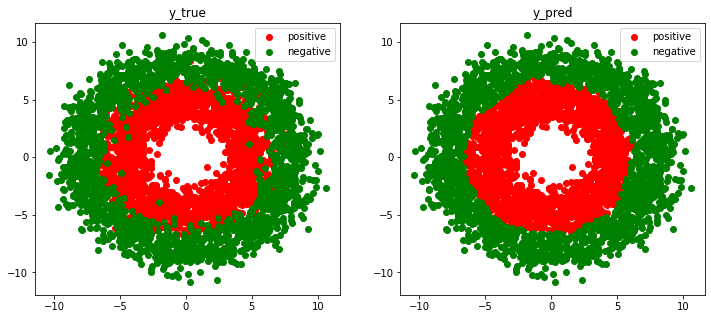

In [28]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(xp[:,0],xp[:,1], c="r")
ax1.scatter(xn[:,0],xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

xp_pred = x[torch.squeeze(model.forward(x)>=0.5)]
xn_pred = x[torch.squeeze(model.forward(x)<0.5)]

ax2.scatter(xp_pred[:,0],xp_pred[:,1],c = "r")
ax2.scatter(xn_pred[:,0],xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

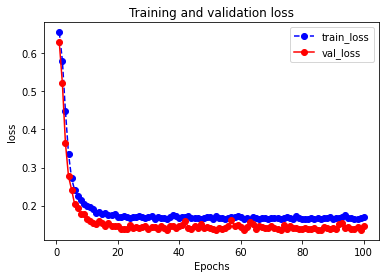

In [29]:
plot_metric(dfhistory,"loss")

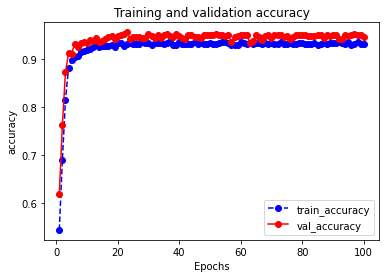

In [30]:
plot_metric(dfhistory,"accuracy")